In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach
import bs4 as bs
import matplotlib as mpl
from scipy.stats import linregress
import scipy

def calc_b_with_time_window(dataframe, n_eq, time_window_center):
    df_window = dataframe.copy()
    time_window_index = df_window.index.get_loc(time_window_center, method='pad')
    
    lower_index = time_window_index - n_eq
    if lower_index < 0:
        lower_index = 0
    
#     df_window = df_window.ix[time_window_index - n_eq : time_window_index + n_eq]
    df_window = df_window.ix[lower_index : time_window_index + n_eq]
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_window.mag)
    return a, b, bstd, n, mc, time_window_index

def calc_b_value_for_parameters(dataframe, parameters, location):
    # TODO: will multiprocessing speed this up?
    rows = []
    for r, t in parameters:
        try:
#             for r, t in parameters:
            df_c = polygon_selection.get_node_data(node=location, data=dataframe, radius=r, m=1)
            df_c = df_c.loc[df_c.index >= t]

            a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_c.mag)
            row = np.array((r,) + (t,) + (a, b, bstd, n, mc) + tuple(location))
            rows.append(row)
        except:
            row = np.array((r,) + (t,) +(np.nan, np.nan, np.nan, np.nan, np.nan) + tuple(location))

    return rows

def calc_b_for_parameters_attr_iter(attr):
    dataframe, parameters, location = attr
    return calc_b_value_for_parameters(dataframe, parameters, location)

def plot_beach_ball(earthquake, m, ax, **kwargs):
    lon, lat = earthquake['coordinates']
    x, y = m(lon, lat)
    b = beach(earthquake['focal_mech'], xy=(x, y), **kwargs)
    b.set_zorder(10)
    ax.add_collection(b)
    
def parse_coords(c):
    c = c.replace('\t', '')
    c = c.replace('\n', '')
    c = c.strip()
    c = c.split(' ')
    c = [[float(co) for co in coord.split(',')] for coord in c]
    c = np.array([np.array(co) for co in c])
    return c

def shape_for_scatter_plot(bdf):
    bdf = bdf[bdf.n >= 50].copy()
    bdf['years before'] = bdf['start_time'].values.astype('datetime64[Y]').astype(int) - 20
    return bdf

def rupture_length(magnitude):
    """
    calculates rupture length using helmstetter relation
    """
    return 0.01 * 10 ** (0.5 * magnitude)

In [2]:
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.3, 'name':'Kumamoto', 'focal_mech':[128  , 71 , -14]}
foreshock1 = {'focal_mech':[299, 79, -10], 'magnitude':6.5, 'coordinates':[130.808667, 32.741667]}
foreshock2 = {'focal_mech':[30, 77, 180], 'magnitude':6.4, 'coordinates':(130.777667, 32.700667)}
rupture_length = rupture_length(7.3)


In [3]:
df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])
eq = kumamoto

df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=3*rupture_length, m=1)
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=25]
df_regional = df_regional[df_regional.mag >= 0.5]

soup = bs.BeautifulSoup(open('/home/max/research/kumamoto/data/kyushu_fault.kml'), 'lxml')
fault_coordinates = [parse_coords(tag.text) for tag in soup.findAll('coordinates')]

# regional seismicity

In [89]:
stats.calc_fmd_stats_with_mc(df_regional[df_regional.distance <= 1.5*rupture_length].mag)

(5.0535495932826269,
 0.79479605004160492,
 0.0042212024698360185,
 31419,
 0.69999999999999996)

# FMDs EVERYWHERE

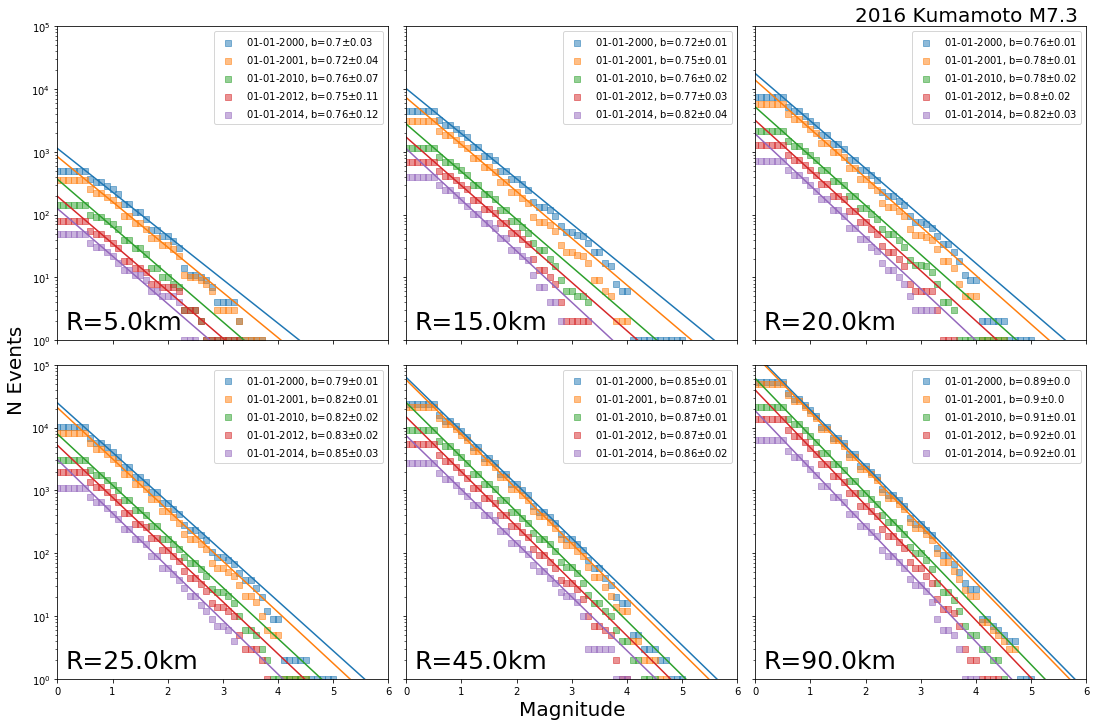

In [4]:
# radius 5
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)

# [item for sublist in l for item in sublist]

ax = [x for sublist in ax for x in sublist]

radii = [5., 15., 20., 25., 45., 90.]
time = ['01-01-2000', '01-01-2001', '01-01-2010', '01-01-2012', '01-01-2014']

# t = time[0]
# for axis in ax:
df_GRs = []

for axis, r in zip(ax, radii):
#     print(r)
    for t in time:
        df_hist = df_regional[df_regional.distance <= r]
        df_hist = df_hist.loc[df_hist.index >= t]
#         df_GRs.append({'radius':r, 'start_time':t, 'df':df_hist})
        hist, edges = np.histogram(a=df_hist.mag.values, bins=100, range=(0, 10))
        chist = np.cumsum(hist[::-1])[::-1]


        a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_hist.mag)
        label = r'{t}, b={b}'.format(t=t, b=round(b, 2))+r'$\pm$'+r'{berr}'.format(berr=round(bstd, 2))
        axis.scatter(edges[:-1], chist, marker='s'
                     , label=label
                     ,alpha=0.5)

        x = np.arange(0, 6, 0.01)
        y = 10**(a - b * x)
        axis.plot(x, y)
#     axis.set_title('radius={r}km'.format(r=r))

    axis.set_yscale('log')
    axis.set_ylim(1e0, 1e5)
    axis.set_xlim(0, 6)
    axis.legend()
    
    axis.text(s='R={r}km'.format(r=round(r,2)), x=0.15, y=1.5e0, fontsize=25)

ax[4].set_xlabel('Magnitude', fontsize=20)

fig.text(-0.0125, 0.5, 'N Events', va='center', rotation='vertical', fontsize=20)

ax[2].text(s='2016 Kumamoto M7.3', x=1.8, y=1.2e5, fontsize=20)

plt.tight_layout()

# print(type(bstd))


fig.savefig('/home/max/Dropbox/Saves/v0003/GR_plots.pdf', bbox_inches='tight')

In [5]:
def D_greater_than_calpha(D, alpha, n, m):
    """
    Compares the KS statistic to expected alpha.
    
    Returns True if significant.
    """
    c_alpha = np.sqrt(-0.5 * np.log(alpha/2.))
    D_comparison = c_alpha * np.sqrt( (n + m) / (n * m) )
    if D > D_comparison:
        return True
    else:
        return False

In [7]:
radii = np.arange(5, (rupture_length * 1.5) + 1, 5)
timii = pd.date_range(start='01-01-1990', end=eq['time'], freq='12M')
radii = np.arange(5, 90, 1)
radii_compare = [ 90,]
depths = np.arange(1, 25, 1)
parameters = [x for x in product(*[radii, radii_compare, timii, depths])]
len(parameters)

55080

In [8]:
def calc_ks_test(params):
#     r1, r2, t1, t2 = params
    r1, r2, t1, d = params
    
    t2 = t1
    
    df1 = df_regional[df_regional.distance <= r1]
    df1 = df1.loc[df1.index >= t1]
    df1 = df1[df1.depth.between(d-1, d+1)]
    
    df2 = df_regional[df_regional.distance <= r2]
    df2 = df2.loc[df2.index >= t2]
    
    a1, b1, bstd1, n1, mc1 = stats.calc_fmd_stats_with_mc(df1.mag)
    a2, b2, bstd2, n2, mc2 = stats.calc_fmd_stats_with_mc(df2.mag)
    
    df1 = df1[df1.mag >= mc1]
    df2 = df2[df2.mag >= mc2]
    
    ks = scipy.stats.ks_2samp(df1.mag, df2.mag)
    
    return r1, r2, d, t1, t2, a1, b1, bstd1, n1, mc1, a2, b2, bstd2, n2, mc2, ks.statistic, ks.pvalue

In [9]:




# radii = np.arange(5, (rupture_length * 1.5) + 1, 5)
# timii = pd.date_range(start='01-01-1990', end=eq['time'], freq='12M')
# # parameters = [x for x in product(*[radii, radii, timii, timii])]
# radii = np.arange(5, 90, 1)
# radii_compare = [45, 90]
# depths
# parameters = [x for x in product(*[radii, radii_compare, timii])]

# def calc_ks_test(params):
# #     r1, r2, t1, t2 = params
#     r1, r2, t1 = params
    
#     t2 = t1
    
#     df1 = df_regional[df_regional.distance <= r1]
#     df1 = df1.loc[df1.index >= t1]
    
#     df2 = df_regional[df_regional.distance <= r2]
#     df2 = df2.loc[df2.index >= t2]
    
#     a1, b1, bstd1, n1, mc1 = stats.calc_fmd_stats_with_mc(df1.mag)
#     a2, b2, bstd2, n2, mc2 = stats.calc_fmd_stats_with_mc(df2.mag)
    
#     df1 = df1[df1.mag >= mc1]
#     df2 = df2[df2.mag >= mc2]
    
#     ks = scipy.stats.ks_2samp(df1.mag, df2.mag)
    
#     return r1, r2, t1, t2, a1, b1, bstd1, n1, mc1, a2, b2, bstd2, n2, mc2, ks.statistic, ks.pvalue

In [10]:


# radii = np.arange(5, (rupture_length * 1.5) + 1, 5)
# timii = pd.date_range(start='01-01-1990', end=eq['time'], freq='12M')
# parameters = [x for x in product(*[radii, radii, timii, timii])]


# def calc_ks_test(params):
#     r1, r2, t1, t2 = params
    
#     df1 = df_regional[df_regional.distance <= r1]
#     df1 = df1.loc[df1.index >= t1]
    
#     df2 = df_regional[df_regional.distance <= r2]
#     df2 = df2.loc[df2.index >= t2]
    
#     a1, b1, bstd1, n1, mc1 = stats.calc_fmd_stats_with_mc(df1.mag)
#     a2, b2, bstd2, n2, mc2 = stats.calc_fmd_stats_with_mc(df2.mag)
    
#     df1 = df1[df1.mag >= mc1]
#     df2 = df2[df2.mag >= mc2]
    
#     ks = scipy.stats.ks_2samp(df1.mag, df2.mag)
    
#     return r1, r2, t1, t2, a1, b1, bstd1, n1, mc1, a2, b2, bstd2, n2, mc2, ks.statistic, ks.pvalue

In [11]:
len(parameters)

55080

In [12]:
from multiprocessing import Pool

pool = Pool()

results = pool.map(calc_ks_test, parameters)
pool.close()

/home/max/pymap3/utilities/stats.py:48: RuntimeWarning: invalid value encountered in double_scalars
  sigma_mag = np.sum([((m - average) ** 2) / (length * (length - 1)) for m in magnitudes])
/home/max/pymap3/utilities/stats.py:48: RuntimeWarning: invalid value encountered in double_scalars
  sigma_mag = np.sum([((m - average) ** 2) / (length * (length - 1)) for m in magnitudes])
/home/max/pymap3/utilities/stats.py:48: RuntimeWarning: invalid value encountered in double_scalars
  sigma_mag = np.sum([((m - average) ** 2) / (length * (length - 1)) for m in magnitudes])
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/scipy/stats/stats.py:4750: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / (1.0*n1)
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/scipy/stats/stats.py:4756: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)

In [13]:
ks_df = pd.DataFrame(results, columns=['r1', 'r2', 'depth_window', 't1', 't2', 'a1', 'b1', 'bstd1', 'n1', 'mc1'
                                         ,'a2', 'b2', 'bstd2', 'n2', 'mc2'
                                         ,'D', 'p-value'])

In [14]:
# ks_df = ks_df[(ks_df.r1 != ks_df.r2) & (ks_df.t1 != ks_df.t2)]

ks_df['D > c_alpha'] = ks_df.apply(lambda row: D_greater_than_calpha(row['D'], 0.01, row['n1'], row['n2']), axis=1)

ks_df['bdiff'] = ks_df.b1 - ks_df.b2

ks_df['rdiff'] = ks_df.r1 - ks_df.r2

ks_df['pass'] = (ks_df['D > c_alpha']==True) & (ks_df['p-value'] <= 0.01)

In [15]:
ks_df.head()

,r1,r2,depth_window,t1,t2,a1,b1,bstd1,n1,mc1,...,b2,bstd2,n2,mc2,D,p-value,D > c_alpha,bdiff,rdiff,pass
0,5,90,1,1990-01-31,1990-01-31,7.817301,8.685890,NaN,1.0,0.7,...,0.80256,0.003532,46199,0.7,0.583259,0.682103,False,7.883329,-85,False
1,5,90,2,1990-01-31,1990-01-31,NaN,NaN,NaN,NaN,NaN,...,0.80256,0.003532,46199,0.7,NaN,NaN,False,NaN,-85,False
2,5,90,3,1990-01-31,1990-01-31,1.690772,1.737178,1.388182,2.0,0.8,...,0.80256,0.003532,46199,0.7,0.340029,0.924697,False,0.934617,-85,False
3,5,90,4,1990-01-31,1990-01-31,3.441883,2.285760,0.612740,5.0,1.0,...,0.80256,0.003532,46199,0.7,0.590727,0.035292,False,1.483200,-85,False
4,5,90,5,1990-01-31,1990-01-31,2.816359,1.579253,0.283536,12.0,1.0,...,0.80256,0.003532,46199,0.7,0.511937,0.002116,True,0.776692,-85,True


In [22]:
ks_df[ks_df.n1 >= 500].describe()/ks_df.describe()

,r1,r2,depth_window,a1,b1,bstd1,n1,mc1,a2,b2,bstd2,n2,mc2,D,p-value,bdiff,rdiff,b,radius,years before
count,0.340251,0.340251,0.340251,0.401040,0.401040,0.420371,0.401040,0.401040,0.340251,0.340251,0.340251,0.340251,3.402505e-01,0.401040,0.401040,0.401040,0.340251,0.401040,0.340251,0.340251
mean,1.204409,1.000000,0.758098,1.117141,0.652101,0.134569,2.366744,0.937988,1.035598,0.985664,0.623856,1.204173,9.947368e-01,0.228165,0.910063,-0.082133,0.776576,0.652101,1.204409,1.214335
std,0.867638,NaN,0.477983,0.158408,0.044491,0.027912,1.200146,0.183746,0.448684,0.939870,0.186212,0.811172,1.022926e-11,0.191324,0.968833,0.035851,0.867638,0.044491,0.867638,0.860829
min,1.400000,1.000000,1.000000,4.679927,1.296137,inf,500.000000,1.000000,1.211926,1.000000,1.000000,6.811644,1.000000e+00,1.000000,1.000000,0.636953,0.976471,1.296137,1.400000,inf
25%,1.538462,1.000000,1.037037,1.490796,1.013760,0.629801,42.956522,1.000000,1.044455,0.969510,0.934714,1.626820,1.000000e+00,0.545577,0.420620,0.742725,0.781250,1.013760,1.538462,1.666667
50%,1.255319,1.000000,0.800000,1.221534,0.979296,0.403778,8.173554,1.000000,1.017245,0.984732,0.878662,1.251505,1.000000e+00,0.287762,0.802952,1.624044,0.720930,0.979296,1.255319,1.230769
75%,1.102941,1.000000,0.657534,1.078259,0.941647,0.196028,2.891489,0.875000,1.000308,0.999595,0.796497,1.045427,1.000000e+00,0.201291,0.899780,0.180873,0.681818,0.941647,1.102941,1.100000
max,1.000000,1.000000,0.666667,0.208844,0.122887,0.022199,1.000000,0.470588,1.000000,0.936874,0.349243,1.000000,8.750000e-01,0.237705,1.000000,0.018369,1.000000,0.122887,1.000000,1.000000


In [54]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

(0.5, 1.2)

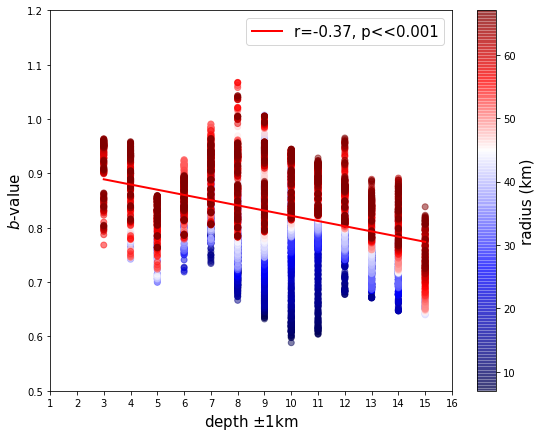

In [83]:
fig, ax = plt.subplots(figsize=(9, 7))


data = ks_df[(ks_df.n1 >= 500) & (ks_df.r1 <= 1.5 * rupture_length)].copy()
# data = ks_df[(ks_df.n1 >= 500) & ks_df['pass']==True].copy()

# data.plot(kind='scatter', x='depth_window', y='b1', c='radius', cmap='seismic', ax=ax
#           ,norm=MidpointNormalize(midpoint=45), alpha=0.5)

cbar = ax.scatter(x=data.depth_window, y=data.b1, c=data.radius, cmap='seismic'
          ,norm=MidpointNormalize(midpoint=45), alpha=0.5, label=None)

cbar = fig.colorbar(cbar)

cbar.set_label(label='radius (km)', fontsize=15)
# avg = data.groupby('depth_window').b1.mean()
x = np.array(sorted(data.depth_window.unique().astype(float)))

LR = linregress(data.depth_window, data.b1)

y = LR.intercept + LR.slope * x

ax.plot(x, y, color='red', linewidth=2, label='r={r}, p<<0.001'.format(r=LR.rvalue.round(2)))
ax.legend(fontsize=15)

ax.set_ylabel('$b$-value', fontsize=15)
ax.set_xlabel('depth $\pm$1km', fontsize=15)

ax.set_xticks(np.arange(1, 17, 1))

ax.set_ylim(0.5, 1.2)

# fig.savefig('/home/max/Dropbox/Saves/v0003/depth_dependency_supplemental.pdf', bbox_inches='tight')

In [84]:
ks_df.groupby('pass').count()/ks_df['pass'].count()

,r1,r2,depth_window,t1,t2,a1,b1,bstd1,n1,mc1,...,mc2,D,p-value,D > c_alpha,bdiff,rdiff,start_time,b,radius,years before
pass,,,,,,,,,,,,,,,,,,,,,
False,0.788017,0.788017,0.788017,0.788017,0.788017,0.636438,0.636438,0.597422,0.636438,0.636438,...,0.788017,0.636438,0.636438,0.788017,0.636438,0.788017,0.788017,0.636438,0.788017,0.788017
True,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983,...,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983,0.211983


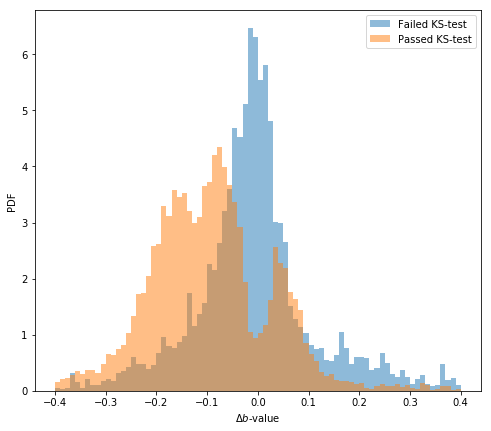

In [85]:
fig, ax = plt.subplots(figsize=(8, 7))

ks_df[ks_df['pass'] == False].bdiff.hist(bins=80, range=(-0.4, 0.4), normed=True, alpha=0.5, label='Failed KS-test')
ks_df[ks_df['pass']==True].bdiff.hist(bins=80, range=(-0.4, 0.4), normed=True, alpha=0.5, label='Passed KS-test')

ax.grid(False)

ax.set_ylabel('PDF')
ax.set_xlabel('$\Delta b$-value')
ax.legend()

ValueError: zero-size array to reduction operation minimum which has no identity

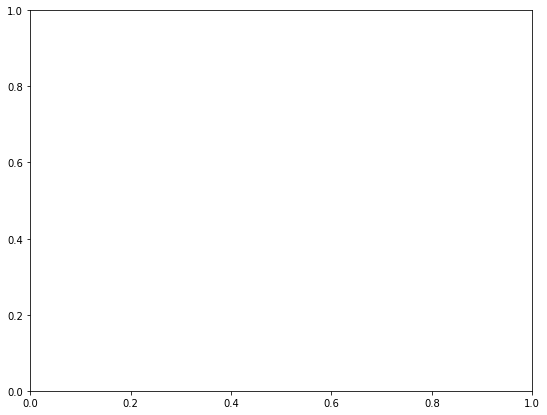

In [86]:
ks_df['start_time'] = ks_df['t1']
ks_df['b'] = ks_df['b1']
ks_df['radius'] = ks_df['r1']
ks_df['years before'] = abs(ks_df['start_time'].values.astype('datetime64[Y]').astype(int) - 46)

data = ks_df[(ks_df['pass']==True) & (ks_df.r2==45) & (ks_df.n1 >= 50)].copy()

zi = data.pivot_table(columns='years before', index='radius', values='b')
yi = zi.index
xi = zi.columns
x, y = np.meshgrid(xi, yi)
zi = np.ma.masked_invalid(zi)

fig, ax = plt.subplots(figsize=(9, 7))

cbar = ax.pcolormesh(x, y, zi, vmin=0.5, vmax=1, cmap='jet')
# plotting.plot_radius_time_sweep(ks_df[ks_df.n1 >=50], 'radius', 'b', fig, ax, vmin=0.6, vmax=0.9, cmap='jet')

ax.set_ylim(0, 45)
ax.set_ylabel('radius (km)', fontsize=15)
ax.set_xlabel('years before kumamoto mainshock', fontsize=15)

fig.colorbar(cbar, label='b-value')

ax.text(s='b-values passing KS-test with\nregional area set at rupture length (45km)', x=25, y=2, fontsize=15)

ax.invert_xaxis()


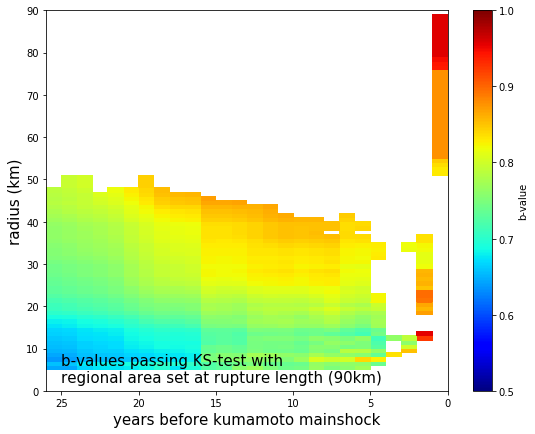

In [513]:
ks_df['start_time'] = ks_df['t1']
ks_df['b'] = ks_df['b1']
ks_df['radius'] = ks_df['r1']
ks_df['years before'] = abs(ks_df['start_time'].values.astype('datetime64[Y]').astype(int) - 46)

data = ks_df[(ks_df['pass']==True) & (ks_df.r2==90) & (ks_df.n1 >= 50)].copy()

zi = data.pivot_table(columns='years before', index='radius', values='b')
yi = zi.index
xi = zi.columns
x, y = np.meshgrid(xi, yi)
zi = np.ma.masked_invalid(zi)

fig, ax = plt.subplots(figsize=(9, 7))

cbar = ax.pcolormesh(x, y, zi, vmin=0.5, vmax=1, cmap='jet')
# plotting.plot_radius_time_sweep(ks_df[ks_df.n1 >=50], 'radius', 'b', fig, ax, vmin=0.6, vmax=0.9, cmap='jet')

ax.set_ylim(0, 90)
ax.set_ylabel('radius (km)', fontsize=15)
ax.set_xlabel('years before kumamoto mainshock', fontsize=15)

fig.colorbar(cbar, label='b-value')

ax.text(s='b-values passing KS-test with\nregional area set at rupture length (90km)', x=25, y=2, fontsize=15)

ax.invert_xaxis()


In [486]:
ks_df[(ks_df['pass']==True) & (ks_df['bdiff']>=0)].bdiff.describe()

count    297.000000
mean       0.033562
std        0.011291
min        0.002724
25%        0.029538
50%        0.033841
75%        0.037127
max        0.104388
Name: bdiff, dtype: float64

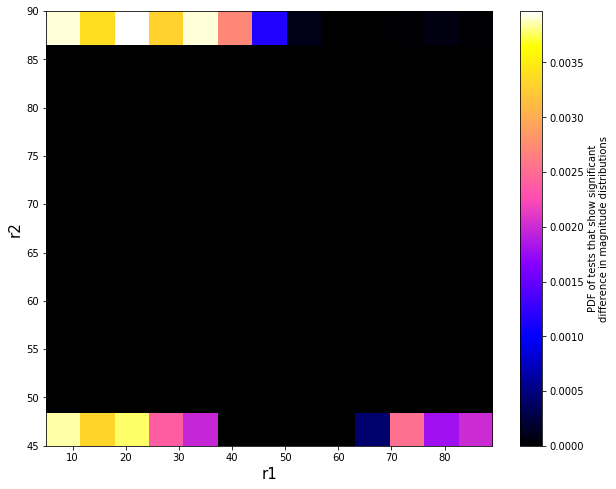

In [487]:
fig, ax =plt.subplots(figsize=(10, 8))

data = ks_df[ks_df['pass']==True]

# ks_df[ks_df['pass']==True].plot(kind='scatter', x='r1', y='r2', ax=ax)

h,e1,e2, cbar = ax.hist2d(data.r1, data.r2, cmap='gnuplot2', bins=13, normed=True)
fig.colorbar(cbar, label='PDF of tests that show significant\ndifference in magnitude distributions')

ax.set_xlabel('r1', fontsize=15)
ax.set_ylabel('r2', fontsize=15)
# ax.set_ylim(0, 100)
# ax.set_xlim(0, 100)

# ax.grid(True)

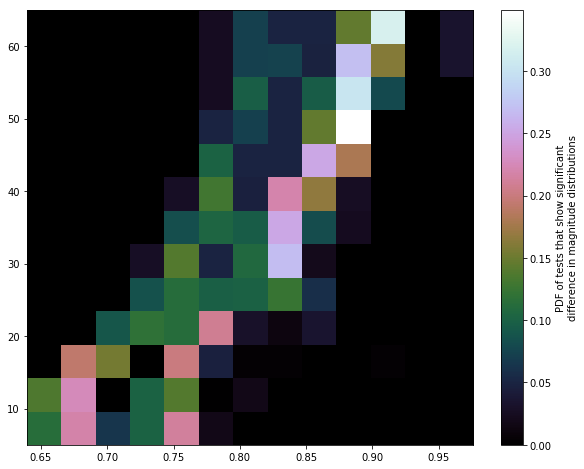

In [252]:
fig, ax =plt.subplots(figsize=(10, 8))

data = ks_df[ks_df['pass']==True]

# ks_df[ks_df['pass']==True].plot(kind='scatter', x='r1', y='r2', ax=ax)

h,e1,e2, cbar = ax.hist2d(data.b1, data.r1, cmap='cubehelix', bins=13, normed=True)
fig.colorbar(cbar, label='PDF of tests that show significant\ndifference in magnitude distributions')

# ax.set_xlabel('r1', fontsize=15)
# ax.set_ylabel('r2', fontsize=15)
# ax.set_ylim(0, 100)
# ax.set_xlim(0, 100)

# ax.grid(True)

In [269]:

def calc_fmd_for_params(params):
    r, t = params
    df_local = df_regional[df_regional.distance <= r]
    df_local = df_local.loc[df_local.index >= t]
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_local.mag)
    depth = df_local.depth.mean()
    return r, t, a, b, bstd, n, mc, depth

In [270]:
from multiprocessing import Pool
pool = Pool()

# rupture_length = 0.01 * 10 ** (0.5 * eq['magnitude'])

radii = np.arange(5, (rupture_length * 1.5) + 1, 1)
timii = pd.date_range(start='01-01-1990', end=eq['time'], freq='1M')
parameters = [x for x in product(radii, timii)]

results = pool.map(calc_fmd_for_params, parameters)
pool.close()

/home/max/pymap3/utilities/stats.py:48: RuntimeWarning: invalid value encountered in double_scalars
  sigma_mag = np.sum([((m - average) ** 2) / (length * (length - 1)) for m in magnitudes])
/home/max/pymap3/utilities/stats.py:48: RuntimeWarning: invalid value encountered in double_scalars
  sigma_mag = np.sum([((m - average) ** 2) / (length * (length - 1)) for m in magnitudes])


In [271]:
bdf = pd.DataFrame(results, columns=['radius', 'start_time', 'a', 'b', 'bstd', 'n', 'mc', 'depth'])

In [272]:
bdf['years before'] = abs(bdf['start_time'].values.astype('datetime64[Y]').astype(int) - 46)

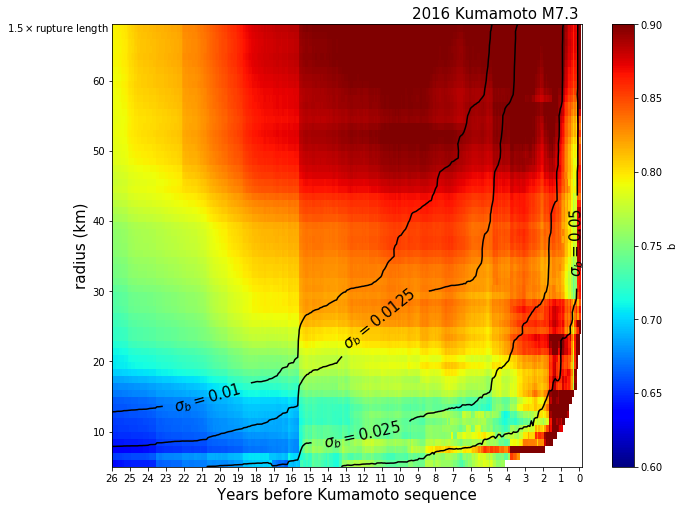

In [273]:
# bdf = pd.read_csv('data/bdf_6_14_2017.csv')


fig, ax = plt.subplots(figsize=(9, 7 ))
plotting.plot_radius_time_sweep(bdf[bdf.n >=50], 'radius', 'b', fig, ax, vmin=0.6, vmax=0.9, cmap='jet')

y = bdf.radius.unique()
x = np.arange(bdf.start_time.unique().shape[0])
x, y = np.meshgrid(x, y)
z = bdf.pivot(index='start_time', columns='radius', values='bstd').values.transpose()

cs = ax.contour(x, y, z, levels=[0.01, 0.0125, 0.025, 0.05], colors='black')
s = r'$\sigma_b=$'
ax.clabel(cs, inline=1, fontsize=15, fmt={0.01:s+'0.01', 0.0125:s+'0.0125', 0.025:s+'0.025', 0.05:s+'0.05'})


ax.text(s='2016 Kumamoto M7.3', x=200, y=1.54*rupture_length, fontsize=15)
ax.text(s=r'$1.5 \times$'+'rupture length', x=-70, y=1.5*rupture_length)
ax.set_ylabel('radius (km)', fontsize=15)

x_labels = abs(bdf['start_time'].values.astype('datetime64[Y]').astype(int) - 46)[::12]
ax.set_xticklabels(x_labels, rotation=0)
ax.set_xlabel('Years before Kumamoto sequence', fontsize=15)

fig.tight_layout()

fig.savefig('/home/max/Dropbox/Saves/v0003/kuma_param_sweep.pdf', bbox_inches='tight')

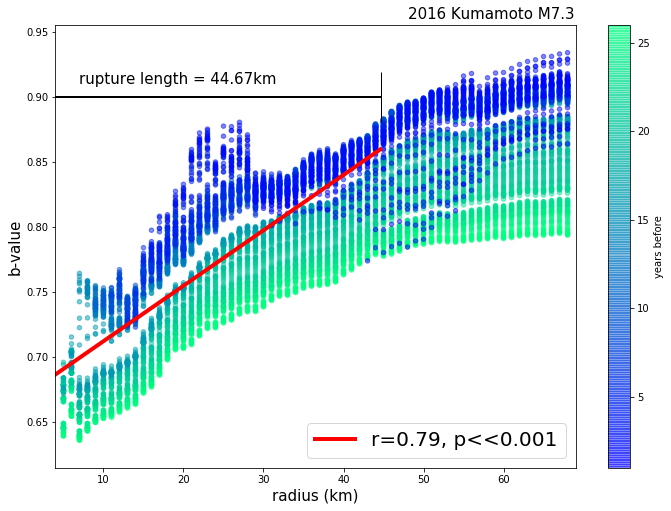

In [274]:
fig, ax = plt.subplots(figsize=(10, 7))

N = 500

# bdf[bdf.n >= 500].plot(kind='scatter', x='radius', y='b', c='years before', alpha=0.5, cmap='winter', ax=ax
bdf[bdf.n >= N].plot(kind='scatter', x='radius', y='b', c='years before', alpha=0.5, cmap='winter', ax=ax
                      , label=None)

ax.text(s='rupture length = {z}km'.format(z=round(rupture_length,2)), x=7, y=0.91, fontsize=15)

ax.set_xlim(4, 1.5*rupture_length + 2)

ax.set_ylabel('b-value', fontsize=15)
ax.set_xlabel('radius (km)', fontsize=15)

ax.text(s='2016 Kumamoto M7.3', x=48, y=0.96, fontsize=15)

x = np.arange(0)

# data = bdf[(bdf.radius <= rupture_length) & (bdf.n >= 500)].copy()
data = bdf[(bdf.radius <= rupture_length) & (bdf.n >= N)].copy()

lreg = linregress(data.radius, data.b)

x = np.arange(0, rupture_length, 0.1)
y = lreg.intercept + lreg.slope * x

ax.plot(x, y, color='red', linewidth=4, label='r={r}, p<<0.001'.format(r=lreg.rvalue.round(2)))

ax.legend(loc='lower right', fontsize=20)
x = (0, rupture_length)
y = (0.9, 0.9)
ax.plot(x, y, marker='|', markersize=50, color='black', linewidth=2, label='None')

# ax.set_ylim(0.5, 1.2)

fig.tight_layout()
# fig.savefig('/home/max/Dropbox/Saves/v0003/radius_vs_b_kumamoto.pdf')

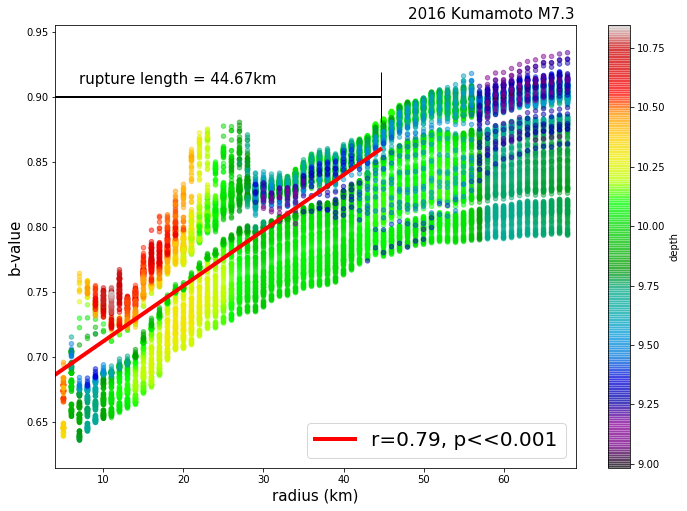

In [275]:
fig, ax = plt.subplots(figsize=(10, 7))

N = 500

# bdf[bdf.n >= 500].plot(kind='scatter', x='radius', y='b', c='years before', alpha=0.5, cmap='winter', ax=ax
bdf[bdf.n >= N].plot(kind='scatter', x='radius', y='b', c='depth', alpha=0.5, cmap='nipy_spectral', ax=ax
                      , label=None)

ax.text(s='rupture length = {z}km'.format(z=round(rupture_length,2)), x=7, y=0.91, fontsize=15)

ax.set_xlim(4, 1.5*rupture_length + 2)

ax.set_ylabel('b-value', fontsize=15)
ax.set_xlabel('radius (km)', fontsize=15)

ax.text(s='2016 Kumamoto M7.3', x=48, y=0.96, fontsize=15)

x = np.arange(0)

# data = bdf[(bdf.radius <= rupture_length) & (bdf.n >= 500)].copy()
data = bdf[(bdf.radius <= rupture_length) & (bdf.n >= N)].copy()

lreg = linregress(data.radius, data.b)

x = np.arange(0, rupture_length, 0.1)
y = lreg.intercept + lreg.slope * x

ax.plot(x, y, color='red', linewidth=4, label='r={r}, p<<0.001'.format(r=lreg.rvalue.round(2)))

ax.legend(loc='lower right', fontsize=20)
x = (0, rupture_length)
y = (0.9, 0.9)
ax.plot(x, y, marker='|', markersize=50, color='black', linewidth=2, label='None')

# ax.set_ylim(0.5, 1.2)

fig.tight_layout()

fig.savefig('/home/max/Dropbox/Saves/v0003/radius_vs_b_kumamoto.pdf')

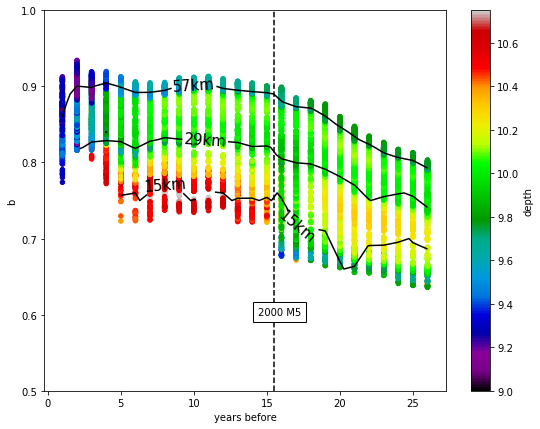

In [462]:
fig, ax = plt.subplots(figsize=(9, 7))

data = bdf[bdf.n>=500].copy()
data['bround'] = data.b.round(2)

data.plot(kind='scatter', x='years before', y='b', c='depth'
          , cmap='nipy_spectral', ax=ax, vmin=9, vmax=10.75)

x = data['years before'].unique()[::-1]
y = data.bround.unique()
X, Y = np.meshgrid(x, y)
Z = data.pivot_table(index='bround', columns='years before', values='radius')

levels = [15, 29, 57]

cs = ax.contour(X, Y, Z, levels=levels, colors='black')
ax.clabel(cs, inline=1, fontsize=15, fmt={15:'15km', 29:'29km', 57:'57km'})

ax.plot([15.5, 15.5], [0.5, 1.0], color='black', linestyle='--')
ax.text(x=14.4, y=0.6, s='2000 M5', bbox={'facecolor':'white', 'alpha':1., 'pad':5})

ax.set_ylim(0.5, 1)

fig.savefig('/home/max/Dropbox/Saves/v0003/b_depth_years_before_supplemental.pdf', bbox_inches='tight')

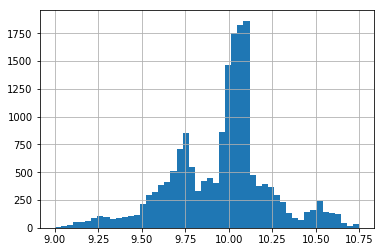

In [449]:
fig, ax = plt.subplots()
data.depth.hist(bins=50, range=(9, 10.75), ax=ax)

 redo the parameter plots using \citet{helmstetter2005importance} equation 9: 
 
 $L(m) = 0.01 \times 10^{0.5m}$ (km) 
 
 to create an upper limit of the selection radius, instead of arbitrarily setting it at 25km

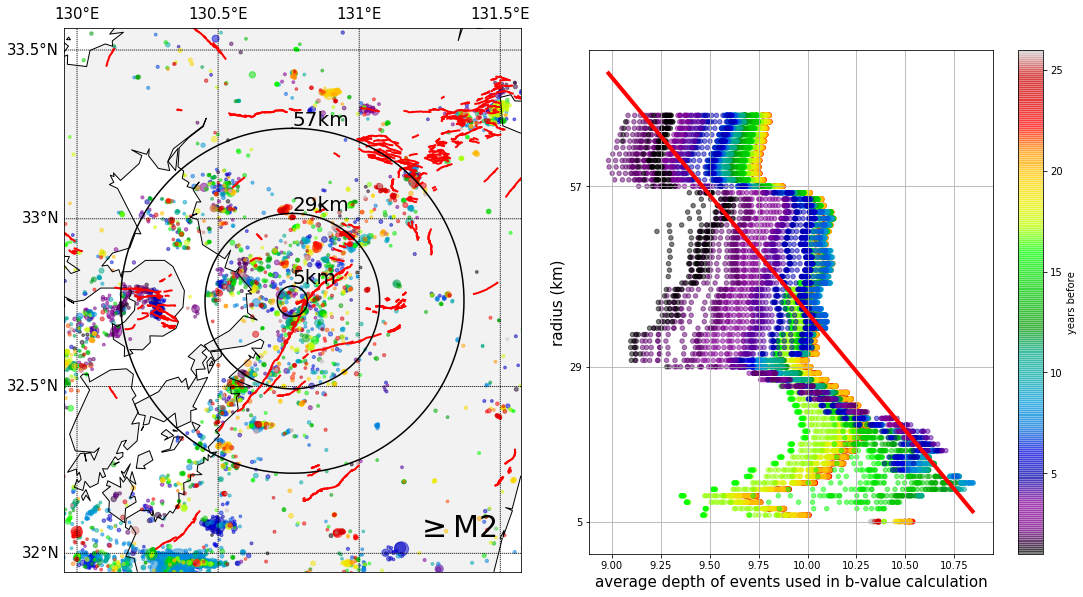

In [340]:
fig, ax = plt.subplots(figsize=(10, 10))

lon, lat = eq['coordinates']

twice_RL = 90.

dist_in_deg = twice_RL/111.111

m = Basemap(projection='merc'
            ,llcrnrlon=lon-dist_in_deg
            ,llcrnrlat=lat-dist_in_deg
            ,urcrnrlon=lon+dist_in_deg
            ,urcrnrlat=lat+dist_in_deg
            , ax=ax
            , resolution='i'
            , area_thresh=1)

m.drawcoastlines()
m.fillcontinents(color='0.95', zorder=0)

lines = np.arange(0, 180, 0.5)
m.drawparallels(lines, labels=[1, 0, 0, 0], fontsize=15)
m.drawmeridians(lines, labels=[0,0,1,0], fontsize=15)

data = df_regional[df_regional.mag >= 2]
x, y = m(data.lon.values, data.lat.values)
# ax.scatter(x=x, y=y, s=np.exp(data.mag), alpha=0.5, color='None', edgecolor='black')
ax.scatter(x=x, y=y, s=np.exp(data.mag), alpha=0.5, c=data['decimal_year'], cmap='nipy_spectral', rasterized=True)

# PLOT FAULT LINES
for fault in fault_coordinates:
    x, y = m(fault[:,0], fault[:,1])
    ax.plot(x, y, color='red', linewidth=2)    

for r in [5, 29, 57]:
    plotting.equi(m=m, radius=r, centerlon=eq['coordinates'][0], centerlat=eq['coordinates'][1]
                 ,color='black')
    x, y = m(eq['coordinates'][0], eq['coordinates'][1]+(r+1)/111.111)
    ax.text(s='{r}km'.format(r=r), x=x, y=y, fontsize=20)

    
x, y = m(131.2, 32.05)
ax.text(s='$\geq$M2', fontsize=30, x=x, y=y)

ax2 = fig.add_axes([0.925, 0.15, 0.7, 0.7])
data = bdf[bdf.n >= 500]

data.plot(kind='scatter', x='depth', y='radius', ax=ax2, c='years before', cmap='nipy_spectral', alpha=0.5
        ,)
lreg = linregress(data.depth, data.radius)

x = np.arange(data.depth.min(), data.depth.max(), 0.01)
y = lreg.intercept + lreg.slope * x

ax2.plot(x, y, color='red', linewidth=4, label='r={r}, p<<0.001'.format(r=lreg.rvalue.round(2)))

ax2.set_ylim(0, 1.75*rupture_length)

ax2.set_xlabel('average depth of events used in b-value calculation', fontsize=15)

ax2.set_ylabel('radius (km)', fontsize=15)

ax2.grid(True)
ax2.set_yticks([5, 29, 57])

fig.savefig('/home/max/Dropbox/Saves/v0003/depth_dependency_supplemental.pdf', bbox_inches='tight')

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


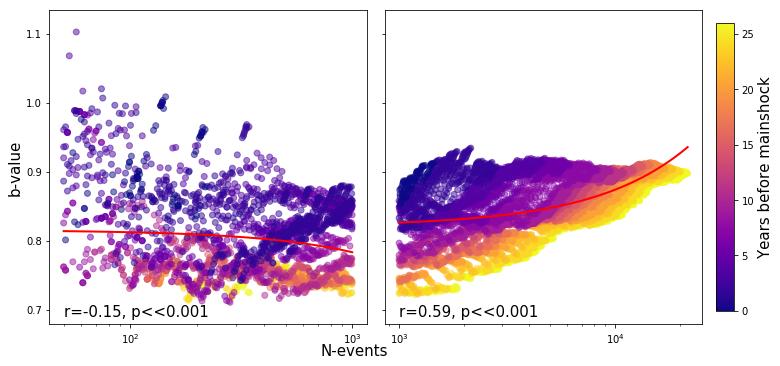

In [267]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)


data = bdf.dropna()
data = data[data.n >= 50]
data = data[data.start_time > '01-01-2001']
def plotneventswithfit(data, ax):
    
#     data.plot(kind='scatter', x='n', y='b', c='years before', alpha=0.5, ax=ax, cmap='plasma')
    
    ax.scatter(x=data.n, y=data.b, c=data['years before'], alpha=0.5, cmap='plasma')
    
    LR = linregress(data.n, data.b)
    ax.text(s='r={r}, p<<0.001'.format(r=LR.rvalue.round(2)), x=data.n.min(), y=0.69, fontsize=15)

    x = np.arange(data.n.min(), data.n.max(), 1)
    y = LR.intercept + LR.slope * x

    ax.plot(x, y, color='red', linewidth=2, label='r={r}, p<<0.001'.format(r=LR.rvalue.round(2)))
    
plotneventswithfit(data[data.n < 1e3], ax)
plotneventswithfit(data[data.n > 1e3], ax2)

fig.text(s='N-events', x=0.45, y=0, fontsize=15)
ax.set_ylabel('b-value', fontsize=15)

ax.set_xscale('log')
ax2.set_xscale('log')

ax5 = fig.add_axes([1.0, 0.125, 0.025, .8])
cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=0, vmax=26)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Years before mainshock', fontsize=15)

fig.tight_layout()

fig.savefig('/home/max/Dropbox/Saves/v0003/radius_vs_n_kuma_supplemental.pdf', bbox_inches='tight')

In [194]:
import statsmodels.api as sm

# X = data[['radius','n']]
X = data[['radius', 'n']]
y = data.b

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      b   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 3.290e+04
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        13:01:50   Log-Likelihood:                -3365.9
No. Observations:               11400   AIC:                             6736.
Df Residuals:                   11398   BIC:                             6750.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         0.0217      0.000    148.515      0.000       0.021       0.022
n          -1.865e-05   8.15e-07    -22.890      0.000   -2.03e-05   -1.71e-05
==============================================================================
Omnibus:                     1381.714   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.236
Skew:                          -0.136   Prob(JB):                     2.47e-86
Kurtosis:                       2.130   Cond. No.                         356.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""